# Starbucks Recommender System

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks.

Not all users receive the same offer, and that is the challenge to solve with this data set.

The task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

The provided transactional data shows user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer.

Let's keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record


In [21]:
import datetime
from google.colab import drive
drive.mount("/content/Drive")
import pandas as pd
import numpy as np
import math
import json
import seaborn as sns
import matplotlib.pyplot as plt
%pip install seaborn==0.11.0

# read in the json files
portfolio = pd.read_json('/content/Drive/MyDrive/ADSFinal/data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('/content/Drive/MyDrive/ADSFinal/data/profile.json', orient='records', lines=True)
transcript = pd.read_json('/content/Drive/MyDrive/ADSFinal/data/transcript.json', orient='records', lines=True)
df = pd.read_csv('/content/Drive/MyDrive/ADSFinal/data/useractions.csv')

Drive already mounted at /content/Drive; to attempt to forcibly remount, call drive.mount("/content/Drive", force_remount=True).


Exloring how the data look like

In [22]:
portfolio

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5


In [23]:
print("Unique offers so far: ", portfolio.id.nunique())

Unique offers so far:  10


In [24]:
profile.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


In [25]:
transcript.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


Now let's explore how many missing data is present

In [26]:
portfolio.isna().sum()

reward        0
channels      0
difficulty    0
duration      0
offer_type    0
id            0
dtype: int64

In [27]:
transcript.isna().sum()

person    0
event     0
value     0
time      0
dtype: int64

In [28]:
transcript.event.value_counts()

transaction        138953
offer received      76277
offer viewed        57725
offer completed     33579
Name: event, dtype: int64

Some of the gender values were set as 'O' and there is many NaN values in the dataset.
This data can be useful for prediction or recoomendadion use cases, so we first need to explore the data and decide if it can be dropped or shoule be marked as non complete.

In [29]:
profile.gender.value_counts()

M    8484
F    6129
O     212
Name: gender, dtype: int64

In [30]:
profile.isna().sum()

gender              2175
age                    0
id                     0
became_member_on       0
income              2175
dtype: int64

In [31]:
# How many customers with NaN as gender and income have responded to offers
null_inc_and_gender = profile[profile.gender.isna()]
person_viewed_offer = transcript[transcript.event == 'offer completed']
nan_responders = pd.merge(null_inc_and_gender, person_viewed_offer, how='inner', left_on=['id'], right_on=['person'])
print(nan_responders['id'].nunique())

788


2175 customers have not filled the gender data and 212 marked as 'O'.
788 of them are active customers that have responded to one or more offers.
We definitely should take this data into account.

# Cleaning the data and Feature Engineering


/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:3704: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:3710: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


<Figure size 1600x500 with 0 Axes>

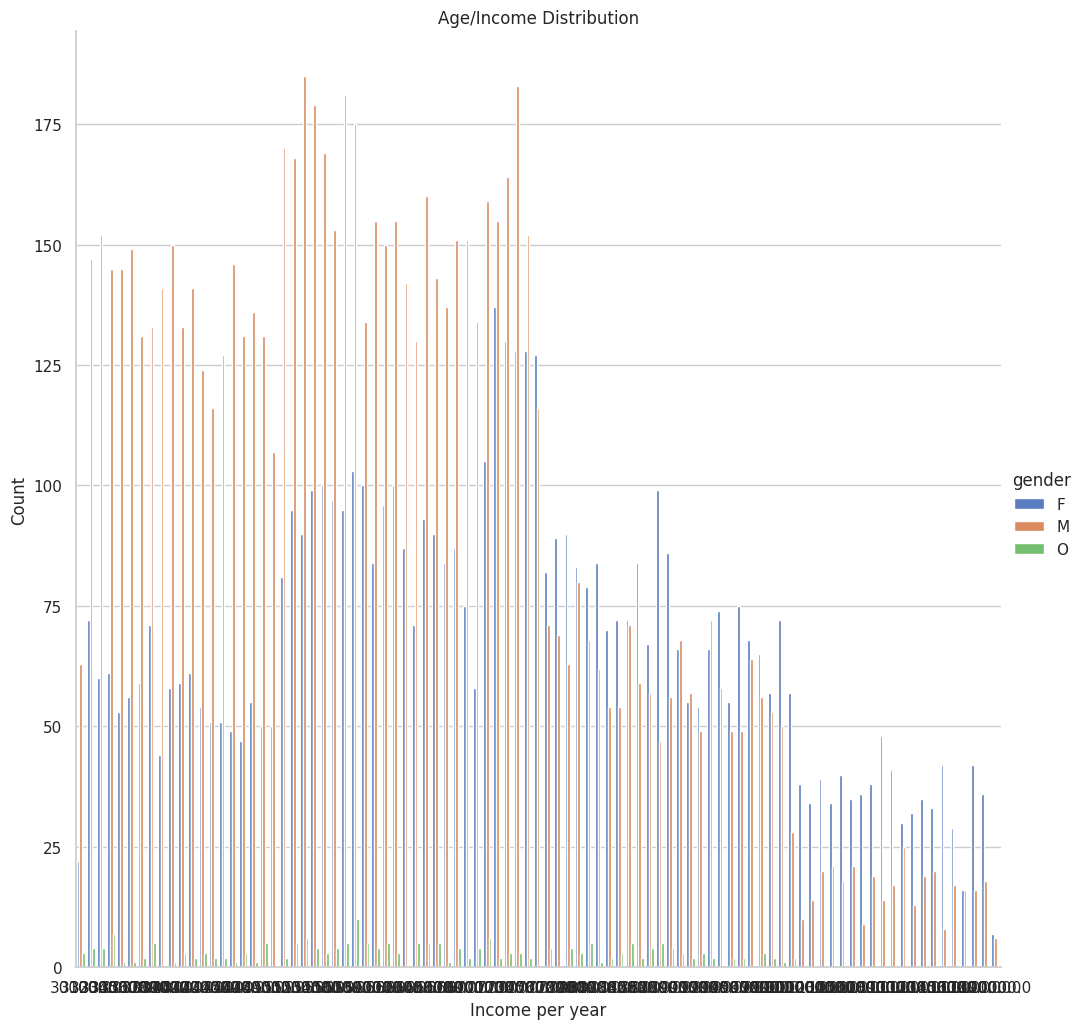

In [32]:
group_income = profile.groupby(['income', 'gender']).size().reset_index()
group_income.columns = ['income', 'gender', 'count']

sns.set(style="whitegrid")
fig= plt.figure(figsize=(16, 5))
sns.factorplot(x="income", y="count", hue="gender", data=group_income, size=10,
                  kind="bar", palette="muted")
plt.xlabel('Income per year')
plt.ylabel('Count')
plt.title('Age/Income Distribution')
plt.savefig('/content/Drive/MyDrive/ADSFinal/images/income-age-dist-binned.png', dpi=fig.dpi)

In [33]:
portfolio['web'] = portfolio['channels'].apply(lambda x: 1 if 'web' in x else 0)
portfolio['email'] = portfolio['channels'].apply(lambda x: 1 if 'email' in x else 0)
portfolio['mobile'] = portfolio['channels'].apply(lambda x: 1 if 'mobile' in x else 0)
portfolio['social'] = portfolio['channels'].apply(lambda x: 1 if 'social' in x else 0)

# apply one hot encoding to offer_type column
offer_type = pd.get_dummies(portfolio['offer_type'])

# drop the channels and offer_type column
portfolio.drop(['channels', 'offer_type'], axis=1, inplace=True)

# combine the portfolio and offer_type dataframe to form a cleaned dataframe
portfolio = pd.concat([portfolio, offer_type], axis=1, sort=False)

In [34]:
print(profile.age.value_counts().head())
profile['memberdays'] = datetime.datetime.today().date() - pd.to_datetime(profile['became_member_on'], format='%Y%m%d').dt.date
profile['memberdays'] = profile['memberdays'].dt.days
profile['income'] = profile['income'].fillna(0)

profile['gender'] = profile['gender'].fillna('X')
profile['gender'] = profile['gender'].map({'X':0,'O':1, 'M':2, 'F':3})
income_bins = [0, 20000, 35000, 50000, 60000, 70000, 90000, 100000, np.inf]
labels = [0,1,2,3,4,5,6,7]
profile['income'] = pd.cut(profile['income'], bins = income_bins, labels= labels, include_lowest=True)
profile['income'].value_counts()

118    2175
58      408
53      372
51      363
54      359
Name: age, dtype: int64


5    3591
2    2889
3    2659
4    2347
0    2175
6    1188
1    1145
7    1006
Name: income, dtype: int64

/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:3704: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:3710: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


Text(0.5, 1.0, 'Age/Income Distribution')

<Figure size 1600x500 with 0 Axes>

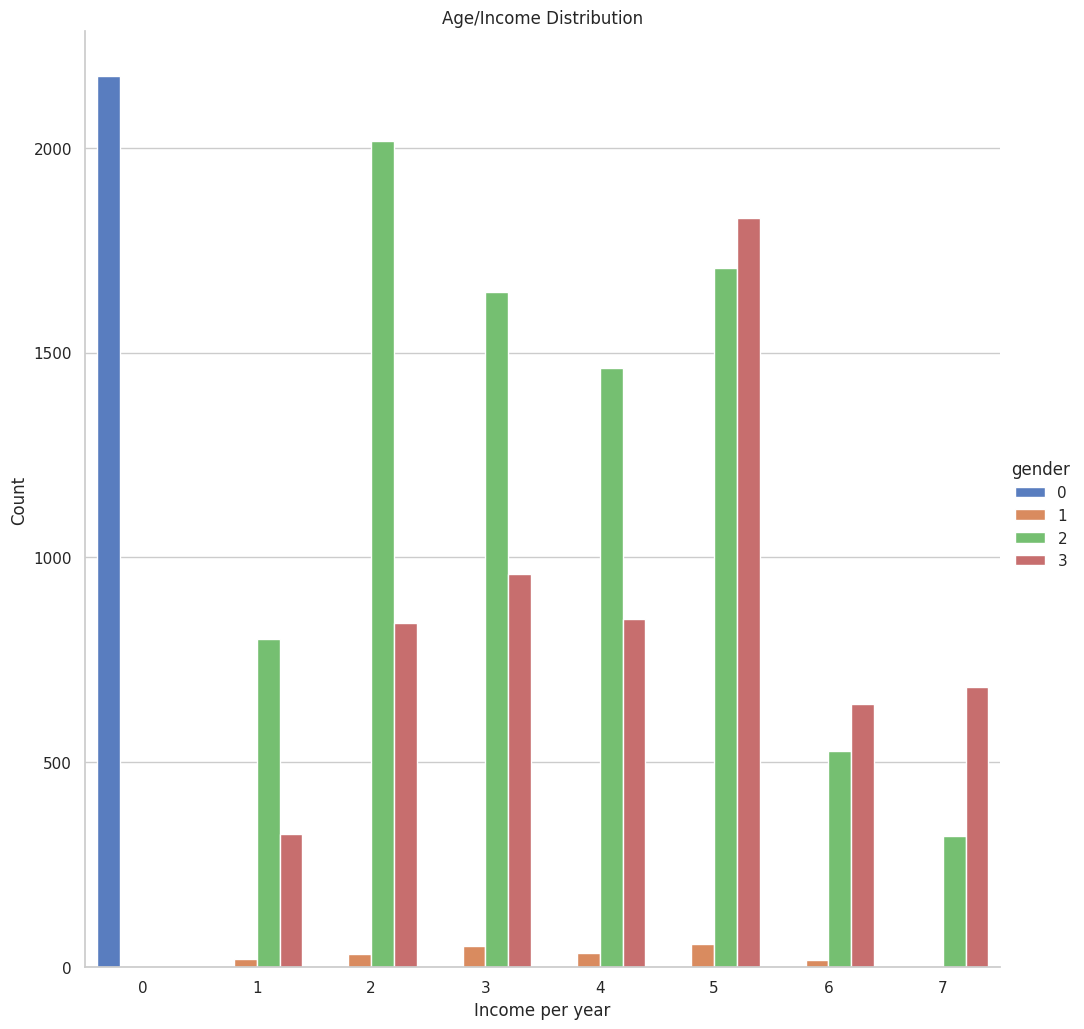

In [35]:
# Let's plot the sama data and see if this provide us with better insights

group_income = profile.groupby(['income', 'gender']).size().reset_index()
group_income.columns = ['income', 'gender', 'count']

sns.set(style="whitegrid")
plt.figure(figsize=(16, 5))
sns.factorplot(x="income", y="count", hue="gender", data=group_income, size=10,
                  kind="bar", palette="muted")
plt.xlabel('Income per year')
plt.ylabel('Count')
plt.title('Age/Income Distribution')
#plt.savefig('./images/income-age-dist-binned.png', dpi=fig.dpi)

Now let's plot more glanural graphs and see how each gender type respond to offers (included anonymized users).

/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:677: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_args = [v for k, v in plot_data.iteritems()]
/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:677: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_args = [v for k, v in plot_data.iteritems()]
/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:677: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_args = [v for k, v in plot_data.iteritems()]
/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:677: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_args = [v for k, v in plot_data.iteritems()]
/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:677: FutureWarning: iteritems is deprecated and will be removed in a fut

(array([ 0.        ,  0.6741573 ,  1.34831461,  2.02247191,  2.69662921,
        3.37078652,  4.04494382,  4.71910112,  5.39325843,  6.06741573,
        6.74157303,  7.41573034,  8.08988764,  8.76404494,  9.43820225,
       10.11235955, 10.78651685, 11.46067416, 12.13483146, 12.80898876,
       13.48314607, 14.15730337, 14.83146067, 15.50561798, 16.17977528,
       16.85393258, 17.52808989, 18.20224719, 18.87640449, 19.5505618 ,
       20.2247191 , 20.8988764 , 21.57303371, 22.24719101, 22.92134831,
       23.59550562, 24.26966292, 24.94382022, 25.61797753, 26.29213483,
       26.96629213, 27.64044944, 28.31460674, 28.98876404, 29.66292135,
       30.33707865, 31.01123596, 31.68539326, 32.35955056, 33.03370787,
       33.70786517, 34.38202247, 35.05617978, 35.73033708, 36.40449438,
       37.07865169, 37.75280899, 38.42696629, 39.1011236 , 39.7752809 ,
       40.4494382 , 41.12359551, 41.79775281, 42.47191011, 43.14606742,
       43.82022472, 44.49438202, 45.16853933, 45.84269663, 46.5

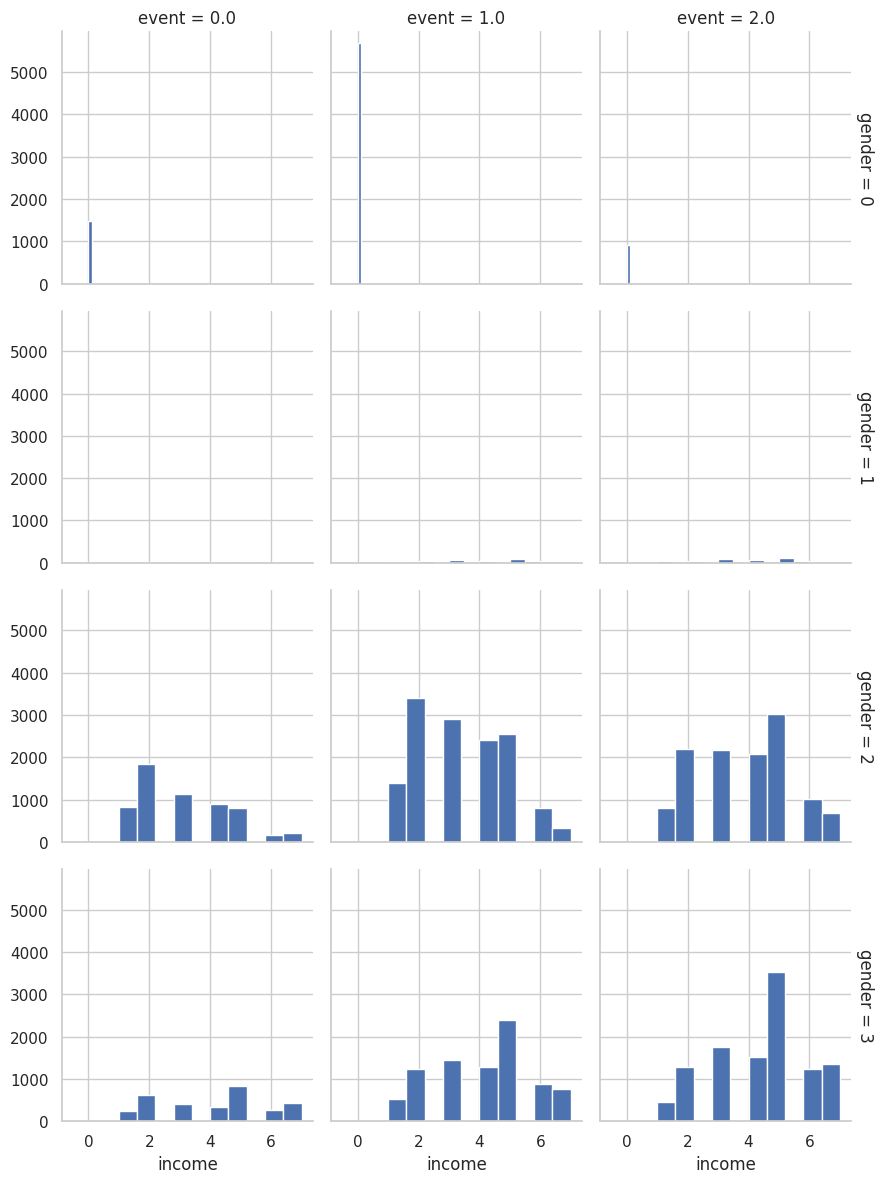

In [36]:
%pip install matplotlib inline
grid = sns.FacetGrid(df, row="gender", col="event", margin_titles=True)
grid.map(plt.hist, "income")
print(np.linspace(0, 60, 90, 100, 150))
#grid.savefig('./images/gender-income-vs-event', dpi=fig.dpi)

Interesting to note that all users that decided to to specify age are also left income per year unspecified. And the amount is quite high as is shown on the above bar plot.
Men also tend to earn more than women, while women tend to respond to an offer more often.

# Exploring correlations

Correlation is used to find which values are closely related with each other.
Now let's describe how values are correlated with each ther. For simplicity - the size of the output dot will define the correlation (the bigger - the closer).

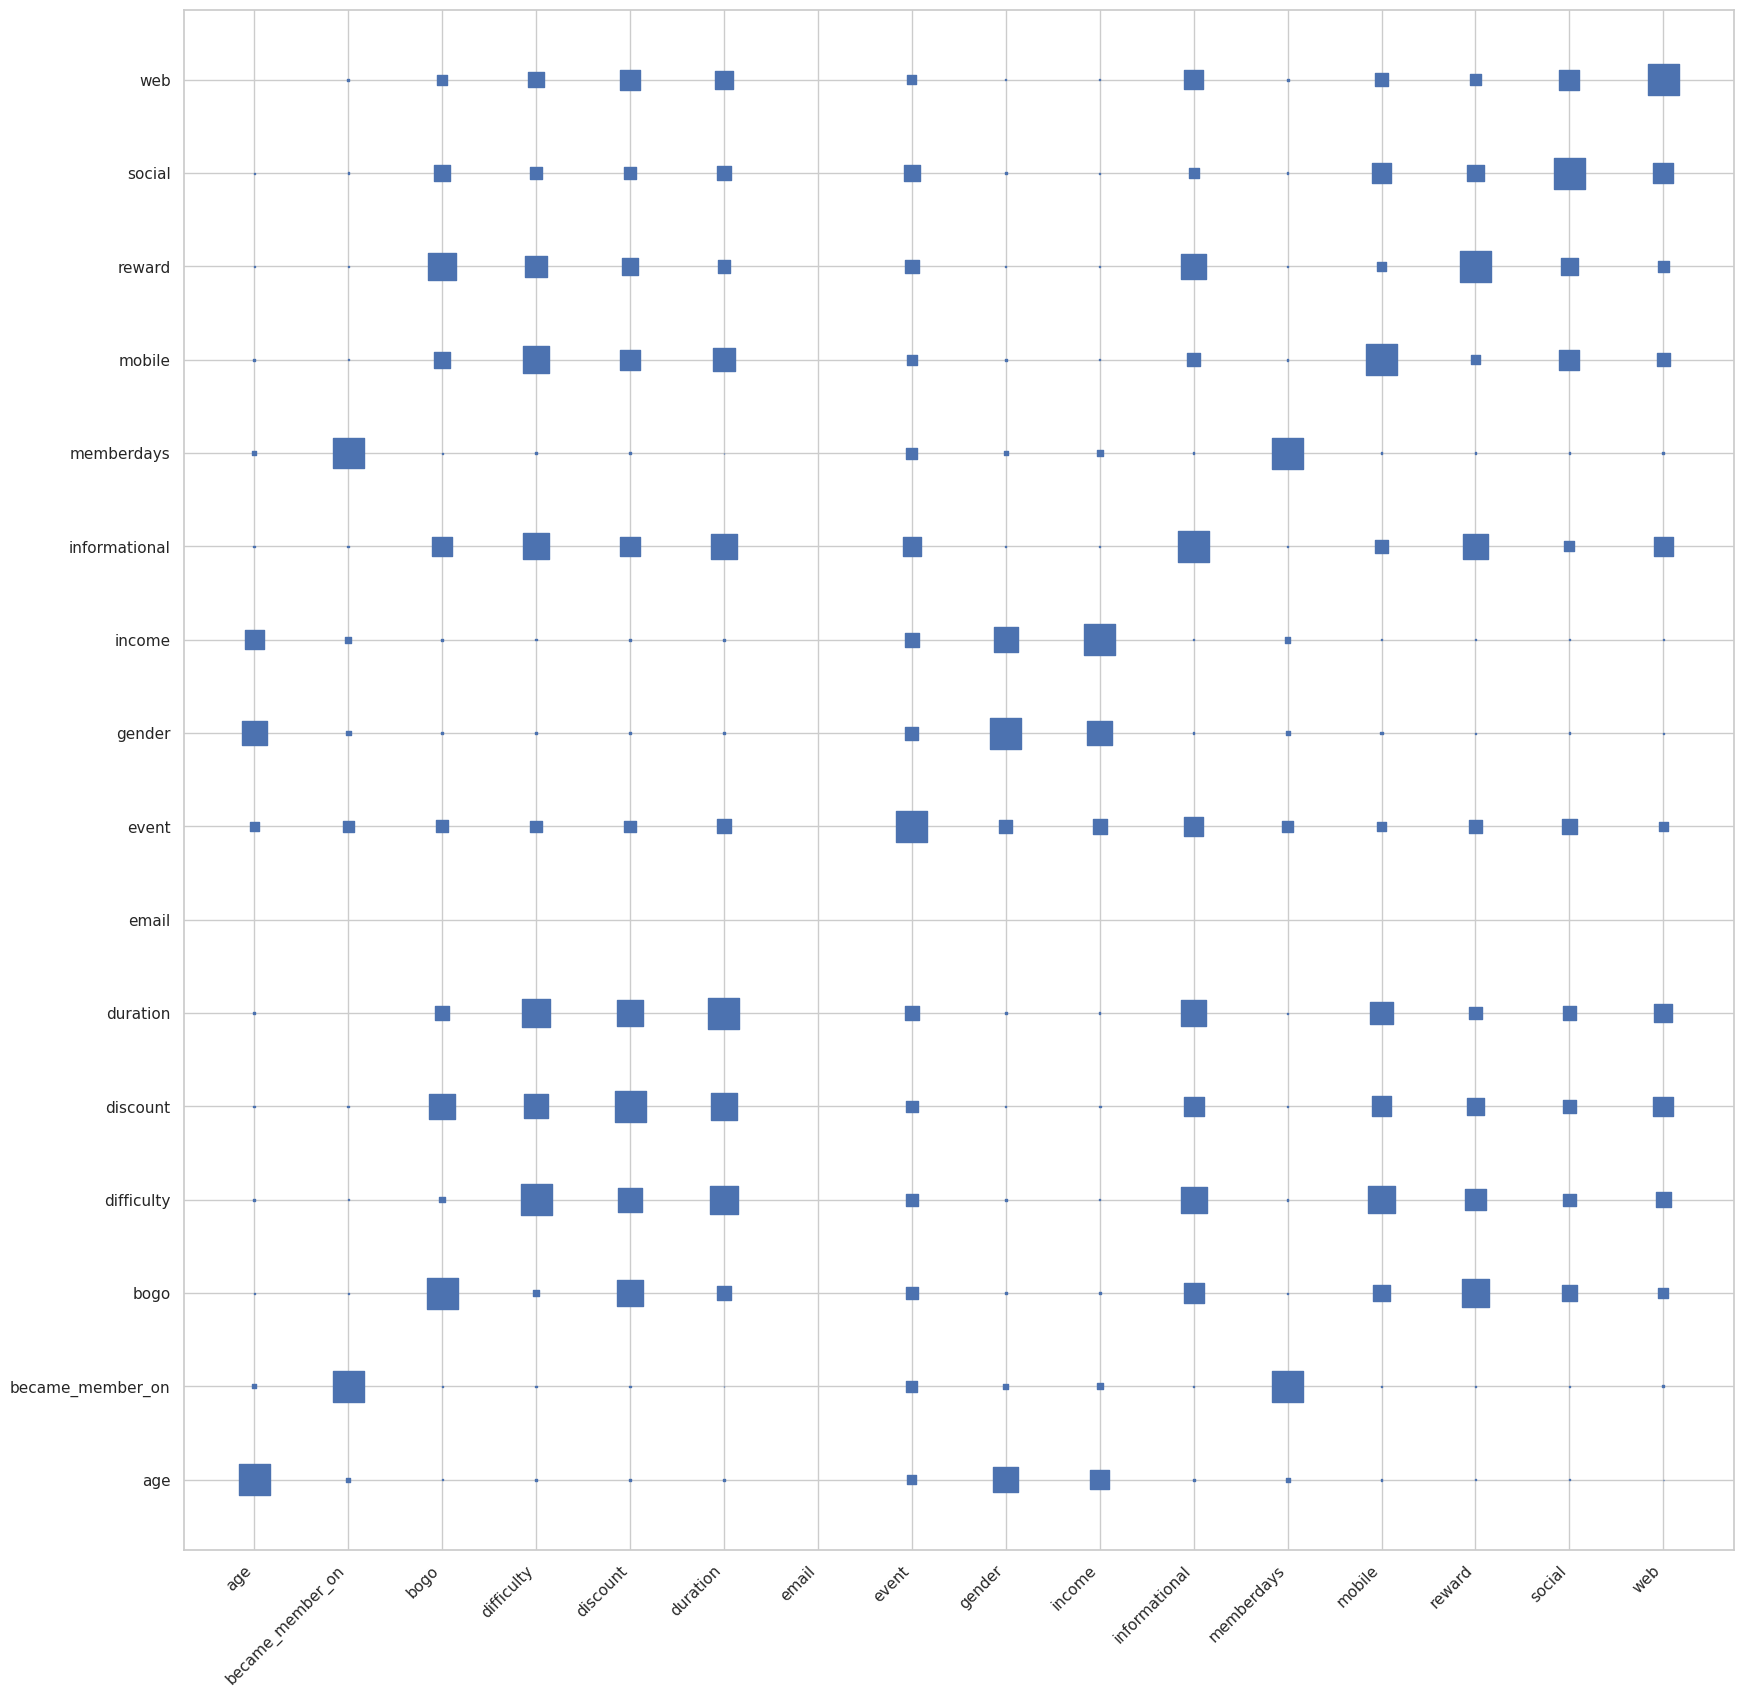

In [38]:
#!mkdir images
def heatmap(x, y, size, figsize=(20,20), fig_name='temp.png'):
    fig, ax = plt.subplots(figsize=figsize)

    # Mapping from column names to integer coordinates
    x_labels = [v for v in sorted(x.unique())]
    y_labels = [v for v in sorted(y.unique())]
    x_to_num = {p[1]:p[0] for p in enumerate(x_labels)}
    y_to_num = {p[1]:p[0] for p in enumerate(y_labels)}

    size_scale = 500
    ax.scatter(
        x=x.map(x_to_num), # Use mapping for x
        y=y.map(y_to_num), # Use mapping for y
        s=size * size_scale, # Vector of square sizes, proportional to size parameter
        marker='s' # Use square as scatterplot marker
    )

    # Show column labels on the axes
    ax.set_xticks([x_to_num[v] for v in x_labels])
    ax.set_xticklabels(x_labels, rotation=45, horizontalalignment='right')
    ax.set_yticks([y_to_num[v] for v in y_labels])
    ax.set_yticklabels(y_labels)
    fig.savefig(fig_name, dpi=fig.dpi)

offer_specs = ['difficulty', 'duration', 'reward', 'web',
       'email', 'mobile', 'social', 'bogo', 'discount', 'informational']
user_specs = ['age', 'became_member_on', 'gender', 'income', 'memberdays']

corr = df[offer_specs + user_specs + ['event']].corr()
corr = pd.melt(corr.reset_index(), id_vars='index') # Unpivot the dataframe, so we can get pair of arrays for x and y
corr.columns = ['x', 'y', 'event']
heatmap(
    x=corr['x'],
    y=corr['y'],
    size=corr['event'].abs(),
    fig_name='/content/Drive/MyDrive/ADSFinal/images/heatmap-general.png'
)

Correlation between features seems to be quite weak. However it can be noted that `bogo` is strongly related to `discount` and `reward` fields, while `mobile` channel is correlated with `difficulty` field. Which is quite expected.

Now let's see more closely into columns of our interest and define if this should be cleaned or changed.

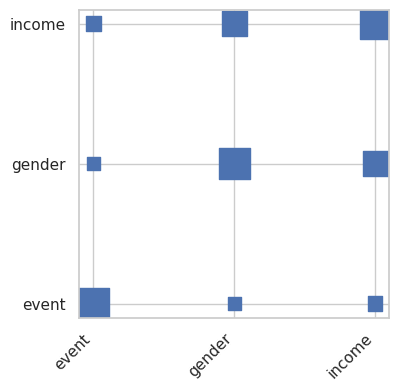

In [39]:
corr = df[['income', 'gender','event']].corr()
corr = pd.melt(corr.reset_index(), id_vars='index') # Unpivot the dataframe, so we can get pair of arrays for x and y
corr.columns = ['x', 'y', 'value']
heatmap(
    x=corr['x'],
    y=corr['y'],
    size=corr['value'].abs(),
    figsize=(4,4),
    fig_name='/content/Drive/MyDrive/ADSFinal/images/heatmap-event.png'
)

If we look closely how event outcome is related to gender or income we can notice that correlation is quite weak, so other additional parameters should be definitely be taken into account.

# Joining the data

To be able to build recoomendation engine we need to merge all datasets and create dataset that will aggregate data each user and what offerts it has responded to.

Let's remind ourselves how the datsets look like

In [40]:
portfolio.head()

,reward,difficulty,duration,id,web,email,mobile,social,bogo,discount,informational
0,10,10,7,ae264e3637204a6fb9bb56bc8210ddfd,0,1,1,1,1,0,0
1,10,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1,1,0,0
2,0,0,4,3f207df678b143eea3cee63160fa8bed,1,1,1,0,0,0,1
3,5,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,1,0,1,0,0
4,5,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,1,0,0,0,1,0


In [41]:
profile.head()

,gender,age,id,became_member_on,income,memberdays
0,0,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,0,2478
1,3,55,0610b486422d4921ae7d2bf64640c50b,20170715,7,2325
2,0,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,0,1963
3,3,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,6,2392
4,0,118,a03223e636434f42ac4c3df47e8bac43,20170804,0,2305


In [42]:
transcript = transcript[transcript.person != None]
transcript.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


Now the data looks good and can be used for predictions.

But we need to create 'Fact Table' that has all information that is needed for prediction wheter customer will respond to an offer.

In [43]:
# extract ids for each offer
transcript['offer_id'] = transcript[transcript.event != 'transaction']['value'].apply(lambda x:
                                                             dict(x).get('offer id')
                                                             if dict(x).get('offer id') is not None
                                                             else dict(x).get('offer_id') )

In [44]:
#transcript['reward'] = transcript['reward'].fillna(0)
transcript.isna().sum()

person           0
event            0
value            0
time             0
offer_id    138953
dtype: int64

In [45]:
transcript.head()

,person,event,value,time,offer_id
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0,9b98b8c7a33c4b65b9aebfe6a799e6d9
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0,0b1e1539f2cc45b7b9fa7c272da2e1d7
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0,2906b810c7d4411798c6938adc9daaa5
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0,fafdcd668e3743c1bb461111dcafc2a4
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0,4d5c57ea9a6940dd891ad53e9dbe8da0


In [46]:
# Transaction offers does ntot have offer id, so we filter them out next

In [47]:
joined_df = pd.merge(profile, transcript[transcript.event != 'transaction'], how='left', left_on=['id'], right_on=['person'])

In [48]:
joined_df.head()

,gender,age,id,became_member_on,income,memberdays,person,event,value,time,offer_id
0,0,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,0,2478,68be06ca386d4c31939f3a4f0e3dd783,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},168.0,2906b810c7d4411798c6938adc9daaa5
1,0,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,0,2478,68be06ca386d4c31939f3a4f0e3dd783,offer viewed,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},216.0,2906b810c7d4411798c6938adc9daaa5
2,0,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,0,2478,68be06ca386d4c31939f3a4f0e3dd783,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},336.0,0b1e1539f2cc45b7b9fa7c272da2e1d7
3,0,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,0,2478,68be06ca386d4c31939f3a4f0e3dd783,offer viewed,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},348.0,0b1e1539f2cc45b7b9fa7c272da2e1d7
4,0,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,0,2478,68be06ca386d4c31939f3a4f0e3dd783,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},408.0,fafdcd668e3743c1bb461111dcafc2a4


In [49]:
joined_df['event'] = joined_df['event'].map({'offer received': 0, 'offer viewed': 1, 'offer completed': 2})
joined_df.head()

,gender,age,id,became_member_on,income,memberdays,person,event,value,time,offer_id
0,0,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,0,2478,68be06ca386d4c31939f3a4f0e3dd783,0.0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},168.0,2906b810c7d4411798c6938adc9daaa5
1,0,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,0,2478,68be06ca386d4c31939f3a4f0e3dd783,1.0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},216.0,2906b810c7d4411798c6938adc9daaa5
2,0,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,0,2478,68be06ca386d4c31939f3a4f0e3dd783,0.0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},336.0,0b1e1539f2cc45b7b9fa7c272da2e1d7
3,0,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,0,2478,68be06ca386d4c31939f3a4f0e3dd783,1.0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},348.0,0b1e1539f2cc45b7b9fa7c272da2e1d7
4,0,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,0,2478,68be06ca386d4c31939f3a4f0e3dd783,0.0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},408.0,fafdcd668e3743c1bb461111dcafc2a4


In [50]:
# Rename column for ease of joining of dataframes
portfolio.rename({'id':'offer_id'}, inplace=True, axis=1)
portfolio.head()

,reward,difficulty,duration,offer_id,web,email,mobile,social,bogo,discount,informational
0,10,10,7,ae264e3637204a6fb9bb56bc8210ddfd,0,1,1,1,1,0,0
1,10,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1,1,0,0
2,0,0,4,3f207df678b143eea3cee63160fa8bed,1,1,1,0,0,0,1
3,5,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,1,0,1,0,0
4,5,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,1,0,0,0,1,0


Now all data can be joined together

In [51]:
df = pd.merge(joined_df, portfolio, how='inner', left_on=['offer_id'], right_on=['offer_id'])
df = df.drop(['person', 'value'], axis=1)
df.head()

,gender,age,id,became_member_on,income,memberdays,event,time,offer_id,reward,difficulty,duration,web,email,mobile,social,bogo,discount,informational
0,0,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,0,2478,0.0,168.0,2906b810c7d4411798c6938adc9daaa5,2,10,7,1,1,1,0,0,1,0
1,0,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,0,2478,1.0,216.0,2906b810c7d4411798c6938adc9daaa5,2,10,7,1,1,1,0,0,1,0
2,2,68,e2127556f4f64592b11af22de27a7932,20180426,4,2040,0.0,0.0,2906b810c7d4411798c6938adc9daaa5,2,10,7,1,1,1,0,0,1,0
3,2,68,e2127556f4f64592b11af22de27a7932,20180426,4,2040,1.0,18.0,2906b810c7d4411798c6938adc9daaa5,2,10,7,1,1,1,0,0,1,0
4,0,118,8ec6ce2a7e7949b1bf142def7d0e0586,20170925,0,2253,0.0,408.0,2906b810c7d4411798c6938adc9daaa5,2,10,7,1,1,1,0,0,1,0


In [52]:
df.columns

Index(['gender', 'age', 'id', 'became_member_on', 'income', 'memberdays',
       'event', 'time', 'offer_id', 'reward', 'difficulty', 'duration', 'web',
       'email', 'mobile', 'social', 'bogo', 'discount', 'informational'],
      dtype='object')

# Building Recommendation matrix

At the moment data for each user has entries for each offer if it was received, viewed and responded to it.
To be able to give valid recoomendations we leave only last user action on each offer (either viewed, responded or ignored).

In [53]:
df[(df.id == '68be06ca386d4c31939f3a4f0e3dd783') & (df.offer_id == '2906b810c7d4411798c6938adc9daaa5')]

,gender,age,id,became_member_on,income,memberdays,event,time,offer_id,reward,difficulty,duration,web,email,mobile,social,bogo,discount,informational
0,0,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,0,2478,0.0,168.0,2906b810c7d4411798c6938adc9daaa5,2,10,7,1,1,1,0,0,1,0
1,0,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,0,2478,1.0,216.0,2906b810c7d4411798c6938adc9daaa5,2,10,7,1,1,1,0,0,1,0


In [54]:
users = df['id'].unique()
offers = df['offer_id'].unique()
recommendation_df = pd.DataFrame(columns=df.columns)

In [55]:
print("Number of known users: ", len(users))
print("Number of created offers: ", len(offers))

Number of known users:  16994
Number of created offers:  10


In [1]:
# Option 1. Filter data, and log progress ...
# This is a very lenghty process, and may tike couple of hours

# for i, offer in enumerate(offers):
#     for j, user in enumerate(users):
#         offer_id_actions = df[(df.id == user) & (df.offer_id == offer)]
#         # log progress
#         if j % 5000 == 0:
#             print('Processing offer %s for user with index: %s' % (i, j))
#             print(offer_id_actions)

#         if len(offer_id_actions) > 1:
#             # user viewed or resonded to offer
#             if offer_id_actions[offer_id_actions.event == 2]['event'].empty == False:
#                 # user has not completed an offer
#                 recommendation_df = recommendation_df.append(offer_id_actions[offer_id_actions.event == 2])
#             elif offer_id_actions[offer_id_actions.event == 1]['event'].empty == False:
#                 # user only viewed offer
#                 recommendation_df = recommendation_df.append(offer_id_actions[offer_id_actions.event == 1])
#             else:
#                 # Offer could be de received multiple times but ignored
#                 #print("Filter length", len())
#                 #print("No event were found in filtered data\n:", offer_id_actions)
#                 recommendation_df = recommendation_df.append(offer_id_actions[offer_id_actions.event == 0])
#         else:
#             # offer has been ignored
#             recommendation_df = recommendation_df.append(offer_id_actions[offer_id_actions.event == 0])
# recommendation_df.head()

In [ ]:
recommendation_df['event'][10000:50000].map({0:'offer received', 1: 'offer viewed', 2: 'offer completed'}).value_counts().plot.pie(figsize=(7, 7),
                                       title="Event Pie Chart",
                                       autopct='%1.1f%%',
                                       legend=True)



### Alternative way of building the matrix

In [58]:
# Option 2. Using Build-it Pandas groupby method and collect the last row in the group
# This might proveide better grouping and insights on how many times each person responed to a particular offer

gr = df.groupby(['id','offer_id'])#.count()

In [59]:
user_actions = pd.concat([gr.tail(1)]).reset_index(drop=True)
  # .sort_values('id')
  # .reset_index(drop=True))

In [60]:
len(user_actions)

63288

In [61]:
user_actions.head()

,gender,age,id,became_member_on,income,memberdays,event,time,offer_id,reward,difficulty,duration,web,email,mobile,social,bogo,discount,informational
0,0,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,0,2478,1.0,216.0,2906b810c7d4411798c6938adc9daaa5,2,10,7,1,1,1,0,0,1,0
1,2,68,e2127556f4f64592b11af22de27a7932,20180426,4,2040,1.0,18.0,2906b810c7d4411798c6938adc9daaa5,2,10,7,1,1,1,0,0,1,0
2,0,118,8ec6ce2a7e7949b1bf142def7d0e0586,20170925,0,2253,1.0,462.0,2906b810c7d4411798c6938adc9daaa5,2,10,7,1,1,1,0,0,1,0
3,0,118,68617ca6246f4fbc85e91a2a49552598,20171002,0,2246,1.0,432.0,2906b810c7d4411798c6938adc9daaa5,2,10,7,1,1,1,0,0,1,0
4,2,65,389bc3fa690240e798340f5a15918d5c,20180209,3,2116,2.0,498.0,2906b810c7d4411798c6938adc9daaa5,2,10,7,1,1,1,0,0,1,0


In [62]:
user_actions[user_actions.id == 'e12aeaf2d47d42479ea1c4ac3d8286c6' ]

,gender,age,id,became_member_on,income,memberdays,event,time,offer_id,reward,difficulty,duration,web,email,mobile,social,bogo,discount,informational
5,2,26,e12aeaf2d47d42479ea1c4ac3d8286c6,20140213,2,3573,0.0,576.0,2906b810c7d4411798c6938adc9daaa5,2,10,7,1,1,1,0,0,1,0
6288,2,26,e12aeaf2d47d42479ea1c4ac3d8286c6,20140213,2,3573,0.0,504.0,0b1e1539f2cc45b7b9fa7c272da2e1d7,5,20,10,1,1,0,0,0,1,0
44327,2,26,e12aeaf2d47d42479ea1c4ac3d8286c6,20140213,2,3573,1.0,414.0,ae264e3637204a6fb9bb56bc8210ddfd,10,10,7,0,1,1,1,1,0,0


<Axes: title={'center': 'Event Pie Chart'}, ylabel='event'>

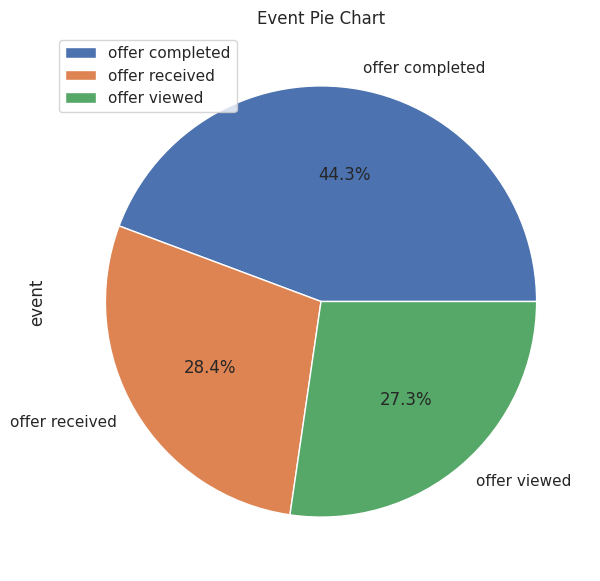

In [63]:
user_actions['event'][0:1000].map({0:'offer received', 1: 'offer viewed', 2: 'offer completed'}).value_counts().plot.pie(figsize=(7, 7),
                                       title="Event Pie Chart",
                                       autopct='%1.1f%%',
                                       legend=True)




Final users/offers datasets look pretty good, however option 2 was not able to extract some actions perfomed by users, especially with filtering duplicates. This might be caused by the fact when offer was received twice.

Let's filter them and explore once more.

In [64]:
user_actions.drop_duplicates(subset=['id', 'offer_id'], keep=False)

user_actions[user_actions.id == 'e12aeaf2d47d42479ea1c4ac3d8286c6' ]

,gender,age,id,became_member_on,income,memberdays,event,time,offer_id,reward,difficulty,duration,web,email,mobile,social,bogo,discount,informational
5,2,26,e12aeaf2d47d42479ea1c4ac3d8286c6,20140213,2,3573,0.0,576.0,2906b810c7d4411798c6938adc9daaa5,2,10,7,1,1,1,0,0,1,0
6288,2,26,e12aeaf2d47d42479ea1c4ac3d8286c6,20140213,2,3573,0.0,504.0,0b1e1539f2cc45b7b9fa7c272da2e1d7,5,20,10,1,1,0,0,0,1,0
44327,2,26,e12aeaf2d47d42479ea1c4ac3d8286c6,20140213,2,3573,1.0,414.0,ae264e3637204a6fb9bb56bc8210ddfd,10,10,7,0,1,1,1,1,0,0


<Axes: title={'center': 'Event Pie Chart'}, ylabel='event'>

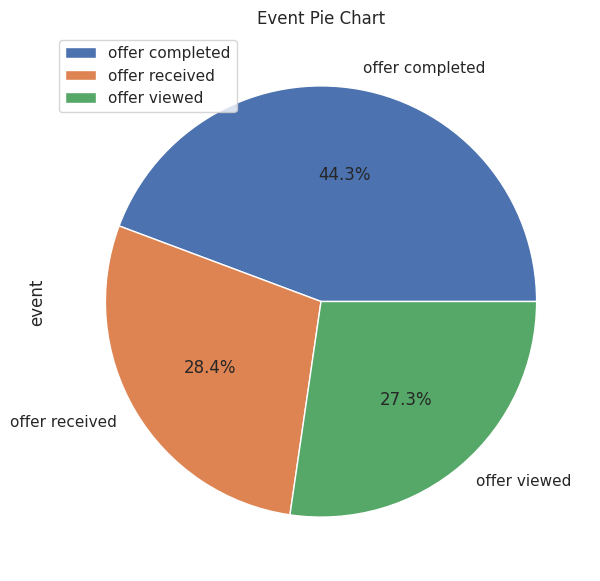

In [65]:
user_actions['event'][0:1000].map({0:'offer received', 1: 'offer viewed', 2: 'offer completed'}).value_counts().plot.pie(figsize=(7, 7),
                                       title="Event Pie Chart",
                                       autopct='%1.1f%%',
                                       legend=True)





Now the matrices look pretty similar and we are ready to build the Recommendation Engine.

In [66]:
recommendation_df.to_csv('userdata.csv', index=False)

In [67]:
user_actions.to_csv('useractions.csv', index=False)